In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Định nghĩa hàm read_plt_file
def read_plt_file(filepath):
    """
    Read a PLT file with improved error handling and timeout protection.
    
    Args:
        filepath (str): Path to the PLT file
        
    Returns:
        pandas.DataFrame: DataFrame containing the parsed data
    """
    # Define column names
    column_names = [
        'latitude', 'longitude', 'zero', 'altitude_feet',
        'date_number', 'date', 'time'
    ]
    
    try:
        # Read the file in chunks to prevent memory issues
        chunks = []
        for chunk in pd.read_csv(
            filepath,
            header=None,
            names=column_names,
            delimiter=',',
            chunksize=10000  # Adjust this value based on your available memory
        ):
            chunks.append(chunk)
        
        if not chunks:
            return pd.DataFrame(columns=column_names)
            
        # Combine all chunks
        df = pd.concat(chunks, ignore_index=True)
        
        # Convert datetime columns
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
        
        # Convert altitude to meters
        df['altitude_meters'] = df['altitude_feet'] * 0.3048
        
        return df
        
    except KeyboardInterrupt:
        print(f"File reading interrupted for {filepath}")
        return pd.DataFrame(columns=column_names)
    except Exception as e:
        print(f"Error reading file {filepath}: {str(e)}")
        return pd.DataFrame(columns=column_names)


# --- Phần chính của chương trình để đọc và xử lý tất cả các tệp .plt ---

# Đường dẫn đến thư mục gốc của dữ liệu GeoLife
# Đảm bảo đường dẫn này khớp với nơi bạn đã giải nén dữ liệu.
# Sử dụng 'r' trước chuỗi để tạo chuỗi thô, tránh lỗi ký tự thoát.
geolife_data_path = r'I:\archive\Geolife Trajectories 1.3\Data'

all_user_data = [] # Danh sách để lưu trữ dữ liệu của tất cả người dùng

print(f"Bắt đầu đọc dữ liệu từ: {geolife_data_path}")

# Duyệt qua các thư mục người dùng (ví dụ: '000', '001', ...)
for user_folder in os.listdir(geolife_data_path):
    user_path = os.path.join(geolife_data_path, user_folder)

    # Đảm bảo đó là một thư mục
    if os.path.isdir(user_path):
        trajectory_path = os.path.join(user_path, 'Trajectory')

        if os.path.isdir(trajectory_path):
            user_id = user_folder # ID người dùng là tên thư mục

            # Duyệt qua từng tệp .plt trong thư mục Trajectory của người dùng
            for filename in os.listdir(trajectory_path):
                if filename.endswith('.plt'):
                    # Tạo đường dẫn đầy đủ đến tệp .plt cụ thể
                    current_filepath = os.path.join(trajectory_path, filename)

                    # Gọi hàm read_plt_file và truyền đường dẫn hiện tại vào
                    df_segment = read_plt_file(current_filepath)

                    if not df_segment.empty:
                        df_segment['user_id'] = user_id
                        all_user_data.append(df_segment)
                        # print(f"  Đã đọc xong tệp: {current_filepath}") # Bỏ comment để xem tiến trình

# Kết hợp tất cả DataFrame thành một DataFrame lớn
if all_user_data:
    full_dataset = pd.concat(all_user_data)
    print(f"\nĐã đọc thành công tổng cộng {len(full_dataset):,} điểm dữ liệu từ tất cả các tệp.")
    print("Dữ liệu 5 hàng đầu tiên:")
    print(full_dataset.head())
    print("\nThông tin về DataFrame:")
    full_dataset.info()
else:
    print("Không tìm thấy dữ liệu nào để đọc hoặc có lỗi xảy ra.")

1. Chuẩn bị dữ liệu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
df = pd.read_csv('your_processed_speed_data.csv')
speed_data = df['speed'].values # Giả sử cột tốc độ có tên là 'speed'
print(f"Tổng số điểm dữ liệu: {len(speed_data)}")
print(f"Tốc độ lấy mẫu: {sampling_rate_per_day} mẫu/ngày")
print(f"Tổng thời gian: {len(speed_data) / sampling_rate_per_day} ngày")

2.  Thực hiện phân tích phổ (FFT)

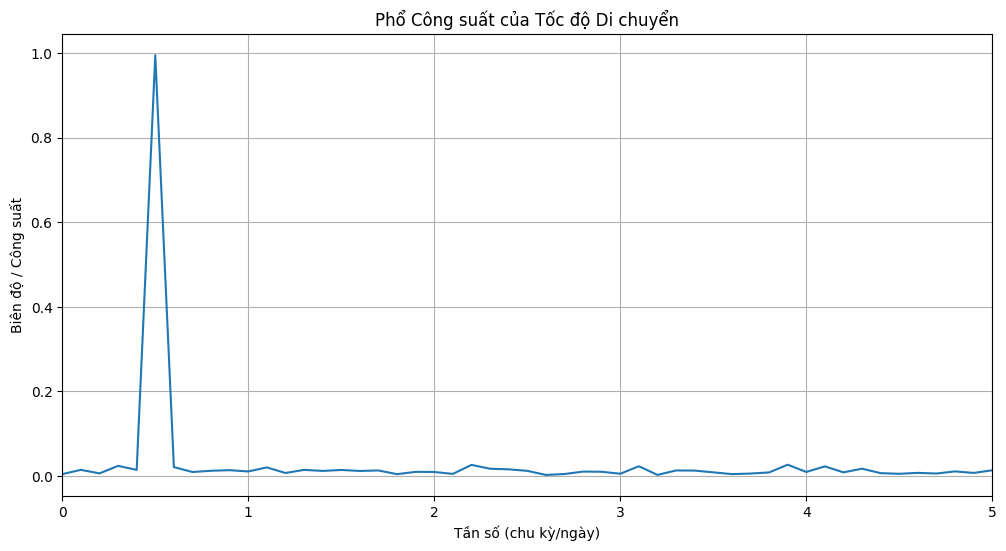

In [22]:
# Thực hiện FFT
N = len(speed_data)
yf = fft(speed_data)
xf = fftfreq(N, 1/sampling_rate_per_day) # Tần số theo chu kỳ/ngày

# Lấy biên độ (power/amplitude spectrum) và chỉ lấy phần dương của tần số
# fftfreq trả về cả tần số âm và dương. Ta chỉ quan tâm đến phần dương.
# Chuẩn hóa để dễ đọc hơn (ví dụ: chia cho N để biên độ không phụ thuộc vào N)
power_spectrum = 2/N * np.abs(yf[0:N//2])
frequencies = xf[0:N//2]

# Trực quan hóa phổ tần số
plt.figure(figsize=(12, 6))
plt.plot(frequencies, power_spectrum)
plt.title('Phổ Công suất của Tốc độ Di chuyển')
plt.xlabel('Tần số (chu kỳ/ngày)')
plt.ylabel('Biên độ / Công suất')
plt.grid(True)
plt.xlim(0, 5) # Giới hạn hiển thị để dễ nhìn các chu kỳ chính (tối đa 5 chu kỳ/ngày)
plt.show()

3. Tìm các chu kỳ lặp lại

In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import os
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Hàm Haversine để tính khoảng cách giữa hai điểm GPS
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Bán kính Trái Đất bằng mét
    # Đảm bảo các giá trị là số thực trước khi chuyển đổi sang radian
    lat1, lon1, lat2, lon2 = float(lat1), float(lon1), float(lat2), float(lon2) # THÊM ÉP KIỂU Ở ĐÂY
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# Hàm read_plt_file đã sửa lỗi và tối ưu từ các cuộc trò chuyện trước
def read_plt_file(filepath):
    column_names = [
        'latitude', 'longitude', 'zero', 'altitude_feet',
        'date_number', 'date', 'time'
    ]
    try:
        df = pd.read_csv(
            filepath,
            header=None,
            names=column_names,
            sep=',',
            engine='python',
            on_bad_lines='skip',
            skiprows=1
        )
        if df.empty:
            return pd.DataFrame()

        # ÉP KIỂU CÁC CỘT TỌA ĐỘ NGAY SAU KHI ĐỌC
        # errors='coerce' sẽ chuyển bất kỳ giá trị nào không thể chuyển đổi thành số thành NaN
        df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
        df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
        df['altitude_feet'] = pd.to_numeric(df['altitude_feet'], errors='coerce') # Đảm bảo altitude cũng là số

        # Loại bỏ các hàng có NaN sau khi ép kiểu
        df.dropna(subset=['latitude', 'longitude', 'altitude_feet'], inplace=True)
        if df.empty:
            print(f"Cảnh báo: Tệp {filepath} không có dữ liệu số hợp lệ sau khi ép kiểu.")
            return pd.DataFrame()

        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
        df.dropna(subset=['datetime'], inplace=True)
        if df.empty:
            print(f"Cảnh báo: Tệp {filepath} không có dữ liệu datetime hợp lệ sau khi loại bỏ NaT.")
            return pd.DataFrame()

        df['altitude_meters'] = df['altitude_feet'] * 0.3048
        df = df.drop(columns=['zero', 'date_number', 'altitude_feet', 'date', 'time'])
        df = df.set_index('datetime')
        df = df.sort_index()
        return df
    except Exception as e:
        print(f"Lỗi nghiêm trọng khi đọc tệp {filepath}: {e}")
        return pd.DataFrame()

# --- Phần chính: Đọc và hợp nhất dữ liệu ---
geolife_data_path = r'I:\archive\Geolife Trajectories 1.3\Data' # Thay đổi đường dẫn của bạn

all_user_data = []
print(f"Bắt đầu đọc dữ liệu từ: {geolife_data_path}")

# Giới hạn số lượng người dùng hoặc tệp để thử nghiệm nhanh hơn
# Bạn có thể bỏ comment hoặc chỉnh sửa lại vòng lặp này
# for user_folder in os.listdir(geolife_data_path)[:5]: # Ví dụ: chỉ đọc dữ liệu của 5 người dùng đầu tiên
for user_folder in os.listdir(geolife_data_path):
    user_path = os.path.join(geolife_data_path, user_folder)

    if os.path.isdir(user_path):
        trajectory_path = os.path.join(user_path, 'Trajectory')

        if os.path.isdir(trajectory_path):
            user_id = user_folder

            # Giới hạn số lượng tệp plt đọc cho mỗi người dùng (ví dụ: 10 tệp đầu tiên)
            # for filename in os.listdir(trajectory_path)[:10]:
            for filename in os.listdir(trajectory_path):
                if filename.endswith('.plt'):
                    filepath = os.path.join(trajectory_path, filename)

                    df_segment = read_plt_file(filepath)

                    if not df_segment.empty:
                        df_segment['user_id'] = user_id
                        all_user_data.append(df_segment)
                    else:
                        print(f"Skipping empty or invalid file: {filename} (User: {user_id})")

if all_user_data:
    full_dataset = pd.concat(all_user_data)
    print(f"\nĐã đọc thành công tổng cộng {len(full_dataset):,} điểm dữ liệu từ tất cả các tệp.")
    print("Dữ liệu 5 hàng đầu tiên:")
    print(full_dataset.head())
    print("\nThông tin về DataFrame:")
    full_dataset.info()
else:
    print("Không tìm thấy dữ liệu nào để đọc hoặc có lỗi xảy ra.")



### Tính toán Tốc độ và Chuẩn bị Chuỗi thời gian cho FFT

# Chọn dữ liệu của một người dùng cụ thể (ví dụ: người dùng '000')
# Thay đổi '000' nếu bạn muốn phân tích người dùng khác
user_id_to_analyze = '000'
user_df = full_dataset[full_dataset['user_id'] == user_id_to_analyze].copy()

if user_df.empty:
    print(f"Không tìm thấy dữ liệu cho người dùng {user_id_to_analyze}. Vui lòng chọn User ID khác hoặc kiểm tra lại dữ liệu.")
else:
    print(f"\nĐang phân tích dữ liệu của người dùng: {user_id_to_analyze}")
    user_df = user_df.sort_index() # Đảm bảo dữ liệu được sắp xếp theo thời gian

    # Tính toán khoảng cách và thời gian
    user_df['prev_latitude'] = user_df['latitude'].shift(1)
    user_df['prev_longitude'] = user_df['longitude'].shift(1)
    user_df['prev_datetime'] = user_df.index.to_series().shift(1)

    user_df.dropna(subset=['prev_latitude', 'prev_longitude', 'prev_datetime'], inplace=True)

    # Đảm bảo các cột tọa độ là số trước khi truyền vào hàm haversine
    # Mặc dù đã ép kiểu trong read_plt_file, nhưng đây là một lớp bảo vệ bổ sung
    user_df['latitude'] = pd.to_numeric(user_df['latitude'], errors='coerce')
    user_df['longitude'] = pd.to_numeric(user_df['longitude'], errors='coerce')
    user_df['prev_latitude'] = pd.to_numeric(user_df['prev_latitude'], errors='coerce')
    user_df['prev_longitude'] = pd.to_numeric(user_df['prev_longitude'], errors='coerce')
    user_df.dropna(subset=['latitude', 'longitude', 'prev_latitude', 'prev_longitude'], inplace=True) # Loại bỏ các hàng nếu ép kiểu thất bại

    user_df['distance_meters'] = user_df.apply(
        lambda row: haversine(row['prev_latitude'], row['prev_longitude'], row['latitude'], row['longitude']),
        axis=1
    )
    user_df['time_diff_seconds'] = (user_df.index - user_df['prev_datetime']).dt.total_seconds()

    user_df['speed_mps'] = user_df['distance_meters'] / user_df['time_diff_seconds']
    user_df['speed_mps'] = user_df['speed_mps'].replace([np.inf, -np.inf], np.nan)
    user_df['speed_mps'].fillna(0, inplace=True)

    user_df['speed_mps'] = user_df['speed_mps'].apply(lambda x: x if x < 50 else 0)

    # --- Bước quan trọng: Lấy mẫu lại chuỗi thời gian tốc độ ---
    time_series_end = user_df.index.max()
    time_series_start = time_series_end - pd.Timedelta(days=30)

    recent_user_df = user_df[(user_df.index >= time_series_start) & (user_df.index <= time_series_end)]

    if not recent_user_df.empty:
        speed_time_series_15min = recent_user_df['speed_mps'].resample('15min').mean().fillna(0)

        full_30_day_index = pd.date_range(start=time_series_start, end=time_series_end, freq='15min')
        your_time_series = speed_time_series_15min.reindex(full_30_day_index, fill_value=0)

        expected_samples = 30 * 24 * 4
        print(f"Đã chuẩn bị chuỗi thời gian tốc độ (30 ngày, mỗi 15 phút) với {len(your_time_series)} điểm.")

        # --- BẮT ĐẦU PHÂN TÍCH FFT TẠI ĐÂY ---
        N = len(your_time_series)
        sampling_rate_per_day = 96 # 96 mẫu/ngày

        yf = fft(your_time_series.values)
        xf = fftfreq(N, 1/sampling_rate_per_day)

        power_spectrum = 2/N * np.abs(yf[0:N//2])**2
        frequencies = xf[0:N//2]

        plt.figure(figsize=(14, 7))
        plt.plot(frequencies, power_spectrum)
        plt.title(f'Phổ Công suất của Tốc độ Di chuyển (Người dùng {user_id_to_analyze})')
        plt.xlabel('Tần số (chu kỳ/ngày)')
        plt.ylabel('Công suất')
        plt.grid(True)
        plt.xlim(0, 5)
        plt.xticks(np.arange(0, 5.1, 0.5))
        plt.show()

        # --- Tìm các chu kỳ nổi bật trong phổ tần số ---
        sorted_indices = np.argsort(power_spectrum)[::-1]

        print("\n--- Các chu kỳ nổi bật được phát hiện ---")
        dominant_cycles = []
        for i in range(len(power_spectrum)):
            idx = sorted_indices[i]
            freq = frequencies[idx]
            amplitude_sq = power_spectrum[idx]

            if freq > 0.001:
                period_days = 1 / freq
                period_hours = period_days * 24

                if amplitude_sq > np.max(power_spectrum) * 0.05:
                    dominant_cycles.append({
                        'Tần số (chu kỳ/ngày)': freq,
                        'Công suất': amplitude_sq,
                        'Chu kỳ (ngày)': period_days,
                        'Chu kỳ (giờ)': period_hours
                    })
            if len(dominant_cycles) >= 5:
                break

        dominant_cycles_df = pd.DataFrame(dominant_cycles)
        if not dominant_cycles_df.empty:
            dominant_cycles_df = dominant_cycles_df.sort_values(by='Chu kỳ (giờ)', ascending=True).reset_index(drop=True)
            print(dominant_cycles_df.round(2).to_string())
        else:
            print("Không tìm thấy chu kỳ nổi bật nào dựa trên ngưỡng đã đặt.")

        print("\nCác chu kỳ thường gặp mà chúng ta kỳ vọng:")
        print("  - Chu kỳ 1 ngày (tần số 1.0 chu kỳ/ngày)")
        print("  - Chu kỳ 0.5 ngày (tần số 2.0 chu kỳ/ngày, tức 12 giờ)")
        print("  - Chu kỳ 7 ngày (tần số ~0.14 chu kỳ/ngày)")

    else:
        print(f"Dữ liệu của người dùng {user_id_to_analyze} không đủ hoặc không có hoạt động trong 30 ngày gần đây.")


Bắt đầu đọc dữ liệu từ: I:\archive\Geolife Trajectories 1.3\Data


4. Trực quan hóa tần suất di chuyển

*4.1. Biểu đồ chuỗi thời gian (Time Series Plot)*

In [ ]:
# Trực quan hóa dữ liệu tốc độ di chuyển theo thời gian (ví dụ 7 ngày đầu tiên)
plt.figure(figsize=(15, 7))
# Tạo trục thời gian theo giờ hoặc ngày
time_points_hours = np.arange(num_samples) / sampling_rate_per_hour
plt.plot(time_points_hours, speed_data)
plt.title('Tốc độ di chuyển theo thời gian')
plt.xlabel('Thời gian (giờ)')
plt.ylabel('Tốc độ (đơn vị/15 phút)')
plt.grid(True)
plt.xlim(0, 7 * 24) # Hiển thị 7 ngày đầu tiên
plt.show()

*4.2. Biểu đồ trung bình theo giờ trong ngày*

In [ ]:
# reshape dữ liệu thành các ngày và tính trung bình theo từng "khung giờ" 15 phút
# Lấy phần dư để ánh xạ về 96 điểm trong một ngày
avg_daily_pattern = np.mean(speed_data.reshape(total_days, sampling_rate_per_day), axis=0)

time_of_day_hours = np.arange(sampling_rate_per_day) / sampling_rate_per_hour

plt.figure(figsize=(10, 6))
plt.plot(time_of_day_hours, avg_daily_pattern)
plt.title('Mẫu Tốc độ Di chuyển Trung bình trong 24 giờ')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Tốc độ trung bình')
plt.xticks(np.arange(0, 25, 4)) # Đặt các mốc giờ 0, 4, 8, 12, 16, 20, 24
plt.grid(True)
plt.show()

*4.3. Biểu đồ trung bình theo ngày trong tuần *

In [ ]:
# Giả định: Bạn có một chuỗi Series trong Pandas với datetime index
# Ví dụ:
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df = df.set_index('timestamp')
# df['day_of_week'] = df.index.dayofweek # Monday=0, Sunday=6

# Giả lập: Gán ngẫu nhiên ngày trong tuần cho dữ liệu giả lập (hoặc lấy từ dữ liệu thực)
# Vì dữ liệu giả lập không có thông tin ngày trong tuần, chúng ta sẽ giả lập nó.
# Mỗi ngày có 96 điểm.
day_of_week_indices = np.floor(np.arange(num_samples) / sampling_rate_per_day) % 7
speed_by_day_of_week = [[] for _ in range(7)]

for i in range(num_samples):
    day_idx = int(day_of_week_indices[i])
    speed_by_day_of_week[day_idx].append(speed_data[i])

avg_speed_by_day_of_week = [np.mean(s) for s in speed_by_day_of_week]

days = ['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ Nhật']

plt.figure(figsize=(10, 6))
plt.bar(days, avg_speed_by_day_of_week, color='skyblue')
plt.title('Tốc độ Di chuyển Trung bình theo Ngày trong Tuần')
plt.xlabel('Ngày trong tuần')
plt.ylabel('Tốc độ trung bình')
plt.grid(axis='y')
plt.show()
# First, we need to calculate the power spectrum
# Assuming you have your time series data in a variable called 'data'
# Let's use numpy's FFT (Fast Fourier Transform)
import numpy as np

# Calculate the FFT
fft_result = np.fft.fft(data)
# Calculate the power spectrum
power_spectrum = np.abs(fft_result)**2

# Now we can find the prominent peaks
sorted_indices = np.argsort(power_spectrum)[::-1]

print("\nCác chu kỳ nổi bật:")
for i in range(5):  # Print the 5 most prominent cycles
    freq = np.fft.fftfreq(len(data))[sorted_indices[i]]
    if freq > 0:  # Only show positive frequencies
        period = 1/freq if freq != 0 else float('inf')
        print(f"Chu kỳ {i+1}: {period:.2f} đơn vị thời gian")